## Calculating Bollinger bands for stock trading

### Importing required libraries

In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

## Special formatting options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like
# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)
%matplotlib inline

In [2]:
## Making a list of tickers to choose from
tickers = ['AAPL','TSLA','GOOGL','NFLX','GOOG','BIDU']

### Setting datetime variables

In [3]:
start_time = datetime.datetime(2021, 1, 1)
# today
end_time = datetime.datetime.now().date().isoformat()

### Getting stock data from Yahoo API

In [4]:
# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        df = web.get_data_yahoo(tickers[1], start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
df = df.reset_index()
print(df.head(5))

connected to yahoo
        Date        High         Low        Open       Close    Volume   Adj Close
0 2021-01-04  744.489990  717.190002  719.460022  729.770020  48638200  729.770020
1 2021-01-05  740.840027  719.200012  723.659973  735.109985  32245200  735.109985
2 2021-01-06  774.000000  749.099976  758.489990  755.979980  44700000  755.979980
3 2021-01-07  816.989990  775.200012  777.630005  816.039978  51498900  816.039978
4 2021-01-08  884.489990  838.390015  856.000000  880.020020  75055500  880.020020


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       377 non-null    datetime64[ns]
 1   High       377 non-null    float64       
 2   Low        377 non-null    float64       
 3   Open       377 non-null    float64       
 4   Close      377 non-null    float64       
 5   Volume     377 non-null    int64         
 6   Adj Close  377 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 20.7 KB


In [7]:
print(f'Maximum date downloaded to the dataframe is {max(df.Date)} and the minimum date is {min(df.Date)}')

Maximum date downloaded to the dataframe is 2022-07-01 00:00:00 and the minimum date is 2021-01-04 00:00:00


In [6]:
##Exporting the data downloaded to a csv file to be used in Tableau for further analysis
df.to_csv('data/tsla_data.csv',index=False)

### Bollinger Bands Function Definition

In [8]:
def bollinger_bands(df, n, m):
    #Parameters:
    # df = dataframe
    # n = smoothing length
    # m = number of standard deviations away from MA
    
    #typical price
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    # but we will use Adj close instead for now, depends
    
    data = TP
    
    # takes one column from dataframe
    MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='MA')
    sigma = data.rolling(n, min_periods=n).std() 
    
    BOLU = pd.Series((MA + m * sigma), name='BOLU')
    BOLD = pd.Series((MA - m * sigma), name='BOLD')
    
    df = df.join(MA)
    df = df.join(BOLU)
    df = df.join(BOLD)
    
    return df

#### Applying the function to the dataframe

In [9]:
n = 20   # datapoint rolling window
m = 2    # sigma width
df = bollinger_bands(df, n, m)
df

,Date,High,Low,Open,Close,Volume,Adj Close,MA,BOLU,BOLD
0,2021-01-04,744.489990,717.190002,719.460022,729.770020,48638200,729.770020,NaN,NaN,NaN
1,2021-01-05,740.840027,719.200012,723.659973,735.109985,32245200,735.109985,NaN,NaN,NaN
2,2021-01-06,774.000000,749.099976,758.489990,755.979980,44700000,755.979980,NaN,NaN,NaN
3,2021-01-07,816.989990,775.200012,777.630005,816.039978,51498900,816.039978,NaN,NaN,NaN
4,2021-01-08,884.489990,838.390015,856.000000,880.020020,75055500,880.020020,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
372,2022-06-27,756.210022,727.700012,748.099976,734.760010,29726100,734.760010,710.819668,781.784649,639.854686
373,2022-06-28,749.909973,697.030029,733.450012,697.989990,30130400,697.989990,709.235834,778.219728,640.251940
374,2022-06-29,693.520020,666.820007,691.500000,685.469971,27632400,685.469971,705.477834,771.613784,639.341884
375,2022-06-30,688.369995,656.590027,673.530029,673.419983,31533500,673.419983,701.729668,766.254052,637.205284


### Plotting daily data and Bollinger Bands

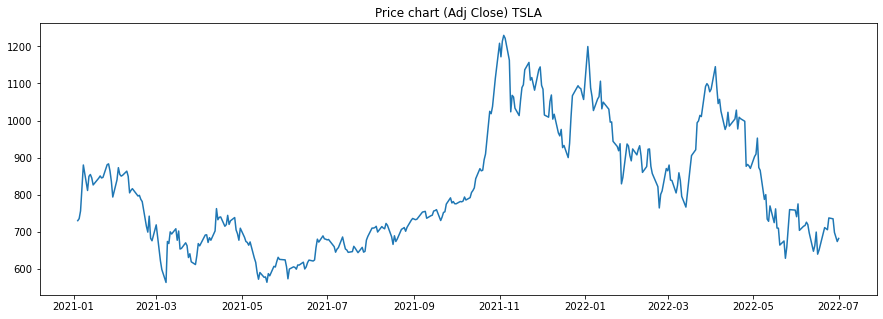

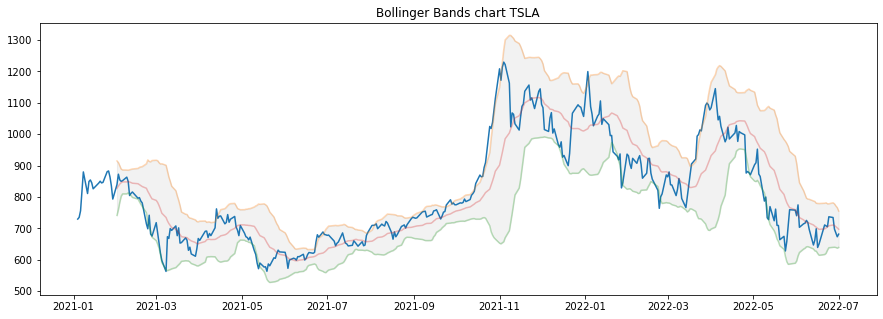

In [10]:
# plot price
plt.figure(figsize=(15,5))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(tickers[1]))
plt.show()

# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('Bollinger Bands chart ' + str(tickers[1]))
plt.plot(df['Date'], df['Adj Close'])
plt.plot(df['Date'], df['BOLU'], alpha=0.3)
plt.plot(df['Date'], df['BOLD'], alpha=0.3)
plt.plot(df['Date'], df['MA'], alpha=0.3)
plt.fill_between(df['Date'], df['BOLU'], df['BOLD'], color='grey', alpha=0.1)

plt.show()